In [25]:
# Import Packages
import pandas as pd
import numpy as np
import shap
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [26]:
# 1. Data Preprocessing
def load_and_preprocess_data(path):
    # Load the dataset from the given path
    df = pd.read_csv(path)
    
    # Define the columns to consider for analysis
    columns_to_consider = ['manufacturer', 'cycle_life', 'b2x', 'location', 'days_since_first_ping', 'corrosion_present']

    # Determine the number of columns and rows for plotting
    num_cols = len(columns_to_consider)
    num_rows = int(np.ceil(num_cols / 3))
    
    # Set up the subplots for the visualization
    fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 4*num_rows))

    # Iterate over each column and plot the distribution
    for idx, col in enumerate(df[columns_to_consider].columns):
        # Determine the appropriate subplot position
        row, col_idx = divmod(idx, 3)
        # Check data type and plot accordingly
        if df[col].dtype == 'bool':
            df[col].value_counts().plot(kind='bar', ax=axes[row, col_idx])
        else:
            df[col].hist(ax=axes[row, col_idx])
        # Set title for each subplot
        axes[row, col_idx].set_title(col)

    # Adjust and display the plot
    plt.tight_layout()
    fig.suptitle('Unchanged Variables', fontsize=16)
    plt.subplots_adjust(top=0.88)  # Adjust subplot parameters to give the title some space
    plt.show()

    # Initialize the label encoder
    le = LabelEncoder()
    mappings = {}
    # Convert categorical variables to encoded numeric values
    for col in ['manufacturer', 'location', 'b2x']:
        df[col] = le.fit_transform(df[col])
        # Store mappings of encoded values to original labels
        mappings[col] = dict(zip(range(len(le.classes_)), le.classes_))
    
    # Define columns that need to be imputed
    cols_to_impute = ['cycle_life', 'days_since_first_ping']
    # Initialize the KNN imputer
    imputer = KNNImputer(n_neighbors=5)
    # Perform the imputation
    imputed_values = imputer.fit_transform(df[columns_to_consider])
    imputed_df = pd.DataFrame(imputed_values, columns=columns_to_consider)
    # Assign the imputed values back to the dataframe
    df[cols_to_impute] = imputed_df[cols_to_impute]
    
    # Fill any remaining missing values in numeric columns with the mean of the column
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        df[col].fillna(df[col].mean(), inplace=True)
    
    # Extract predictors (X) and target variable (y) for model training
    X = df[['manufacturer', 'cycle_life', 'b2x', 'location', 'days_since_first_ping']]
    y = df['corrosion_present']

    # Visualization after filling missing values
    num_cols = len(X.columns)
    num_rows = int(np.ceil(num_cols / 3))
    fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 4*num_rows))
    for idx, col in enumerate(X.columns):
        row, col_idx = divmod(idx, 3)
        if X[col].dtype == 'bool':
            X[col].value_counts().plot(kind='bar', ax=axes[row, col_idx])
        else:
            X[col].hist(ax=axes[row, col_idx])
        axes[row, col_idx].set_title(col)
    plt.tight_layout()
    fig.suptitle('Missing Values Filled', fontsize=16)
    plt.subplots_adjust(top=0.88)
    plt.show()

    # Plotting distribution of target variable
    fig, ax = plt.subplots(figsize=(7, 5))
    y.value_counts().plot(kind='bar', ax=ax, title='Target Distribution before Resampling')
    plt.show()

    # Return the predictors, target, and label mappings
    return X, y, mappings, df


In [27]:
# 2. Data Resampling
def resample_data(X_train, y_train):
    # Initialize SMOTE (Synthetic Minority Over-sampling Technique) 
    # It's a technique to handle imbalanced datasets by creating synthetic samples
    smote = SMOTE(random_state=42)
    
    # Use SMOTE to resample the training data to balance the classes
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    # Calculate the number of columns and rows required for the visualization
    num_cols = len(X_resampled.columns)
    num_rows = int(np.ceil(num_cols / 3))
    
    # Set up the subplots for the visualization
    fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 4*num_rows))

    # Loop through each column in the resampled dataset to visualize its distribution
    for idx, col in enumerate(X_resampled.columns):
        # Determine the correct position for each subplot
        row, col_idx = divmod(idx, 3)
        # Check if the data type is boolean and then plot accordingly
        if X_resampled[col].dtype == 'bool':
            X_resampled[col].value_counts().plot(kind='bar', ax=axes[row, col_idx])
        else:
            X_resampled[col].hist(ax=axes[row, col_idx])
        # Set the title for each subplot
        axes[row, col_idx].set_title(col)

    # Adjust the plots and display them
    plt.tight_layout()
    fig.suptitle('Variables after Resampling', fontsize=16)
    plt.subplots_adjust(top=0.88)
    plt.show()

    # Display the distribution of the target variable after resampling
    fig, ax = plt.subplots(figsize=(7, 5))
    y_resampled.value_counts().plot(kind='bar', ax=ax, title='Target Distribution after Resampling')
    plt.show()

    # Return the resampled data
    return X_resampled, y_resampled

In [28]:
# 3. Model Hyperparameter Optimization
def optimize_hyperparameters(X_train, y_train, n_evals):
    # Define the hyperparameters space:
    # - n_estimators: Number of boosting rounds or trees to build. It's important to tune it properly. Higher values can lead to overfitting.
    # - max_depth: Maximum depth of a tree. Increasing this value will make the model more complex and likely to overfit.
    # - learning_rate: Step size shrinkage to prevents overfitting. Lower values make the optimization more robust.
    # - gamma: Minimum loss reduction required to make a further partition.
    # - min_child_weight: Minimum sum of instance weight (hessian) needed in a child.
    # - subsample: Fraction of training data to grow trees and prevent overfitting.
    # - colsample_bytree: Fraction of features used per tree. High value can lead to overfitting.
    space = {
        'n_estimators': hp.quniform('n_estimators', 50, 500, 1),
        'max_depth': hp.quniform('max_depth', 1, 15, 1),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
        'gamma': hp.uniform('gamma', 0, 1),
        'min_child_weight': hp.uniform('min_child_weight', 1, 10),
        'subsample': hp.uniform('subsample', 0.1, 1),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1),
    }

    # Define the objective function for the hyperopt library to optimize.
    # The function will be minimized; hence we return the negative average precision.
    def objective(params):
        # Transform continuous variables to their respective formats
        params = {
            'n_estimators': int(params['n_estimators']),
            'max_depth': int(params['max_depth']),
            'learning_rate': params['learning_rate'],
            'gamma': params['gamma'],
            'min_child_weight': params['min_child_weight'],
            'subsample': params['subsample'],
            'colsample_bytree': params['colsample_bytree'],
            'scale_pos_weight': sum(y_train == 0) / sum(y_train == 1), # handle class imbalance
            'eval_metric': 'aucpr' # Use Area Under the Curve - Precision Recall as the evaluation metric
        }
    
        # Instantiate the XGBClassifier with the parameters
        clf = XGBClassifier(**params)
        
        # Use 5-fold stratified cross-validation for robustness
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        # Evaluate model using cross-validation and compute the average precision
        scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='average_precision')
        average_precision = np.mean(scores)
        
        # Since hyperopt minimizes the objective, we negate the score
        return {'loss': -average_precision, 'status': STATUS_OK}

    # Instantiate Trials to keep track of all results
    trials = Trials()
    
    # Use Tree-structured Parzen Estimator (TPE) as the search algorithm
    # and find the best hyperparameters over the defined space
    best = fmin(objective, space, algo=tpe.suggest, max_evals=n_evals, trials=trials)
    print(best)
    
    return best


In [29]:
# 4. Model Training
def train_model(X_train, y_train, X_test, y_test, best_params):
    # Reformatting the hyperparameters to the appropriate datatypes:
    # - Some hyperparameters might have been returned from the optimization step as float 
    #   even if they are meant to be integers (like n_estimators and max_depth). 
    #   Here we ensure they are in the correct format.
    best_params = {
        'n_estimators': int(best_params['n_estimators']),     # Number of boosting rounds or trees
        'max_depth': int(best_params['max_depth']),           # Maximum depth of a tree
        'learning_rate': best_params['learning_rate'],        # Step size shrinkage to prevent overfitting
        'gamma': best_params['gamma'],                        # Minimum loss reduction required to make a further partition
        'min_child_weight': best_params['min_child_weight'],  # Minimum sum of instance weight needed in a child
        'subsample': best_params['subsample'],                # Fraction of training data to grow trees
        'colsample_bytree': best_params['colsample_bytree']   # Fraction of features used per tree
    }

    # Instantiate the XGBoost Classifier with the optimal hyperparameters:
    # - XGBoost is a gradient boosted decision tree algorithm.
    # - The best parameters were previously found using a hyperparameter optimization method.
    model = XGBClassifier(**best_params)
    
    # Fit the model using the training data:
    # - This step will train the model using the provided training samples (X_train and y_train).
    model.fit(X_train, y_train)
    
    # Return the trained model.
    # This model can now be used for predictions on new/unseen data.
    return model


In [30]:
# 5. Model Evaluation
def evaluate_model(model, X_test, y_test):
    # Predict the class labels using the trained model
    preds = model.predict(X_test)
    
    # Predict the probabilities of each class
    probs = model.predict_proba(X_test)

    # Create a figure of size 15x12 to hold multiple plots
    plt.figure(figsize=(15, 12))

    # 1. Confusion Matrix
    plt.subplot(2, 2, 1)  # This specifies (2 x 2) grid, 1st plot
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, preds)
    # Define custom labels to better describe the matrix
    labels = ['True Neg','False Pos','False Neg','True Pos']
    labels = np.asarray(labels).reshape(2,2)
    # Convert matrix counts to strings to display
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    # Combine the counts with the labels
    labels_counts = [f"{v1}\n{v2}" for v1, v2 in zip(labels.flatten(), counts)]
    labels_counts = np.asarray(labels_counts).reshape(2,2)
    # Use heatmap to visually represent the confusion matrix
    sns.heatmap(cm, annot=labels_counts, fmt='', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix', fontsize = 15)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # 2. AUC-PR Curve
    plt.subplot(2, 2, 2)  # This specifies (2 x 2) grid, 2nd plot
    # Calculate precision and recall values for varying thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, probs[:, 1])
    plt.plot(recall, precision)
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')

    # 3. ROC Curve
    plt.subplot(2, 2, 3)  # This specifies (2 x 2) grid, 3rd plot
    # Calculate true positive rate and false positive rate for varying thresholds
    fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc_score(y_test, probs[:, 1]):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Add a diagonal dotted line (represents random guessing)
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='best')

    # 4. Classification Report (as table)
    plt.subplot(2, 2, 4)  # This specifies (2 x 2) grid, 4th plot
    # Generate classification metrics (precision, recall, fscore, and support)
    report = precision_recall_fscore_support(y_test, preds)
    precision = report[0]
    recall = report[1]
    fscore = report[2]
    support = report[3]
    labels = ["No Corrosion", "Corrosion"]
    columns = ["Precision", "Recall", "F-score", "Support"]
    cell_text = []
    for i, label in enumerate(labels):
        cell_text.append([f"{precision[i]:.2f}", f"{recall[i]:.2f}", f"{fscore[i]:.2f}", f"{support[i]:.0f}"])
    avg_precision = np.average(precision, weights=support)
    avg_recall = np.average(recall, weights=support)
    avg_fscore = np.average(fscore, weights=support)
    cell_text.append([f"{avg_precision:.2f}", f"{avg_recall:.2f}", f"{avg_fscore:.2f}", f"{np.sum(support):.0f}"])
    labels.append("avg/total")
    plt.axis('off')  # Turn off axis
    plt.title('Classification Report')
    # Create a table to display the classification report
    table = plt.table(cellText=cell_text, colLabels=columns, rowLabels=labels, loc='center', cellLoc = 'center', colWidths=[0.2]*4)
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)  # Scale the table size

    plt.tight_layout()  # Ensures no overlap between subplots
    plt.show()  # Display the figure with all plots


In [31]:
# 6. Feature Analysis
def feature_analysis(model, X_test, features_list, mappings):

    # Nested function to compute bin colors for SHAP value histograms
    def compute_bin_colors(values, shap_values, bins):
        bin_means = []
        for i in range(len(bins) - 1):
            # Create mask for values within each bin
            bin_mask = (values >= bins[i]) & (values < bins[i+1])
            if np.any(bin_mask):  # Check if there are any values in the bin
                # Calculate the mean of SHAP values within the bin
                mean_shap = np.mean(shap_values[bin_mask])
                bin_means.append(mean_shap)
            else:
                bin_means.append(0)
        # Normalize values to [0, 1] for colormapping
        max_bin_mean = max(np.max(bin_means), 1e-10)  # avoid division by zero
        bin_means = np.array(bin_means) / max_bin_mean
        return bin_means

    # Nested function to plot histograms based on SHAP value contributions
    def plot_histogram(ax, pos_contrib, neg_contrib, pos_weights, neg_weights):
        # Create histograms for positive and negative SHAP value contributions
        pos_counts, pos_bins = np.histogram(pos_contrib, bins=30)
        neg_counts, neg_bins = np.histogram(neg_contrib, bins=30)
        pos_bin_colors = compute_bin_colors(pos_contrib, pos_weights, pos_bins)
        neg_bin_colors = compute_bin_colors(neg_contrib, neg_weights, neg_bins)
        ax.bar(pos_bins[:-1], pos_counts, width=np.diff(pos_bins), align="edge", color=plt.cm.Blues(pos_bin_colors), label='Positive Contribution')
        ax.bar(neg_bins[:-1], neg_counts, width=np.diff(neg_bins), align="edge", color=plt.cm.Greens(neg_bin_colors), label='Negative Contribution')

    # Extract feature names from the test dataset
    feature_names = X_test.columns.tolist()

    # Get the importance score for each feature from the model
    feature_importances = model.feature_importances_

    # Create a dictionary to map feature names to their importance scores
    feature_importances_dict = dict(zip(feature_names, feature_importances))

    # Display the importance of each feature, sorted in descending order of importance
    print("Feature importance:")
    for feature, importance in sorted(feature_importances_dict.items(), key=lambda item: item[1], reverse=True):
        print(f"{feature}: {importance}")

    # Calculate SHAP values using the Tree Explainer
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # Check for binary or multiclass classification and adjust SHAP values accordingly
    if isinstance(shap_values, list):
        shap_values = shap_values[1] if len(shap_values) == 2 else shap_values

    # Visualize the summary of SHAP values for all features
    shap.initjs()
    shap.summary_plot(shap_values, X_test)

    # Visualize the distribution of SHAP values for specified features
    for feature in features_list:
        idx = feature_names.index(feature)

        if len(shap_values.shape) == 2:
            feature_shap_values = shap_values[:, idx]
        else:
            feature_shap_values = shap_values[idx]

        # Extract the actual values and SHAP values for positive and negative contributions
        feature_values = X_test[feature].values
        positive_contributions = feature_values[feature_shap_values > 0]
        negative_contributions = feature_values[feature_shap_values < 0]
        positive_weights = np.abs(feature_shap_values[feature_shap_values > 0])
        negative_weights = np.abs(feature_shap_values[feature_shap_values < 0])

        # Create three subplots for negative, positive, and both SHAP contributions
        fig, ax = plt.subplots(3, 1, figsize=(6, 9))

        # Plot negative SHAP value contributions
        plot_histogram(ax[0], [], negative_contributions, [], negative_weights)
        ax[0].set_title(f'Negative SHAP Contributions for {feature}')
        ax[0].set_ylabel('Frequency')
        ax[0].legend()

        # Plot positive SHAP value contributions
        plot_histogram(ax[1], positive_contributions, [], positive_weights, [])
        ax[1].set_title(f'Positive SHAP Contributions for {feature}')
        ax[1].set_ylabel('Frequency')
        ax[1].legend()

        # Plot both positive and negative SHAP value contributions
        plot_histogram(ax[2], positive_contributions, negative_contributions, positive_weights, negative_weights)
        ax[2].set_title(f'Both SHAP Contributions for {feature}')
        ax[2].set_xlabel(feature)
        ax[2].set_ylabel('Frequency')
        ax[2].legend()

        # Display the plots
        plt.tight_layout()
        plt.show()

        # If there are mappings provided for the current feature, print them
        if feature in mappings:
            print(feature, mappings[feature])
        
    return


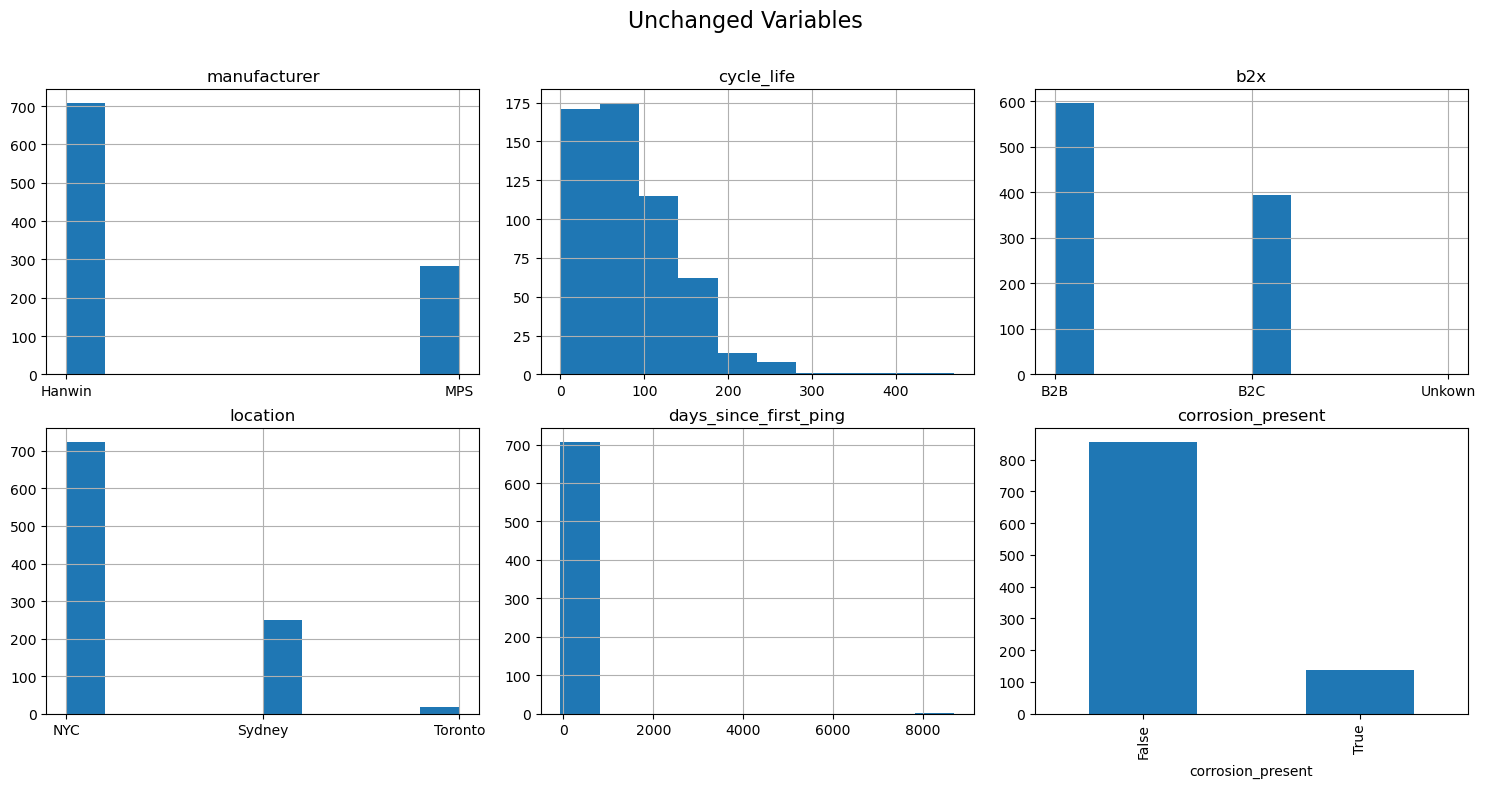

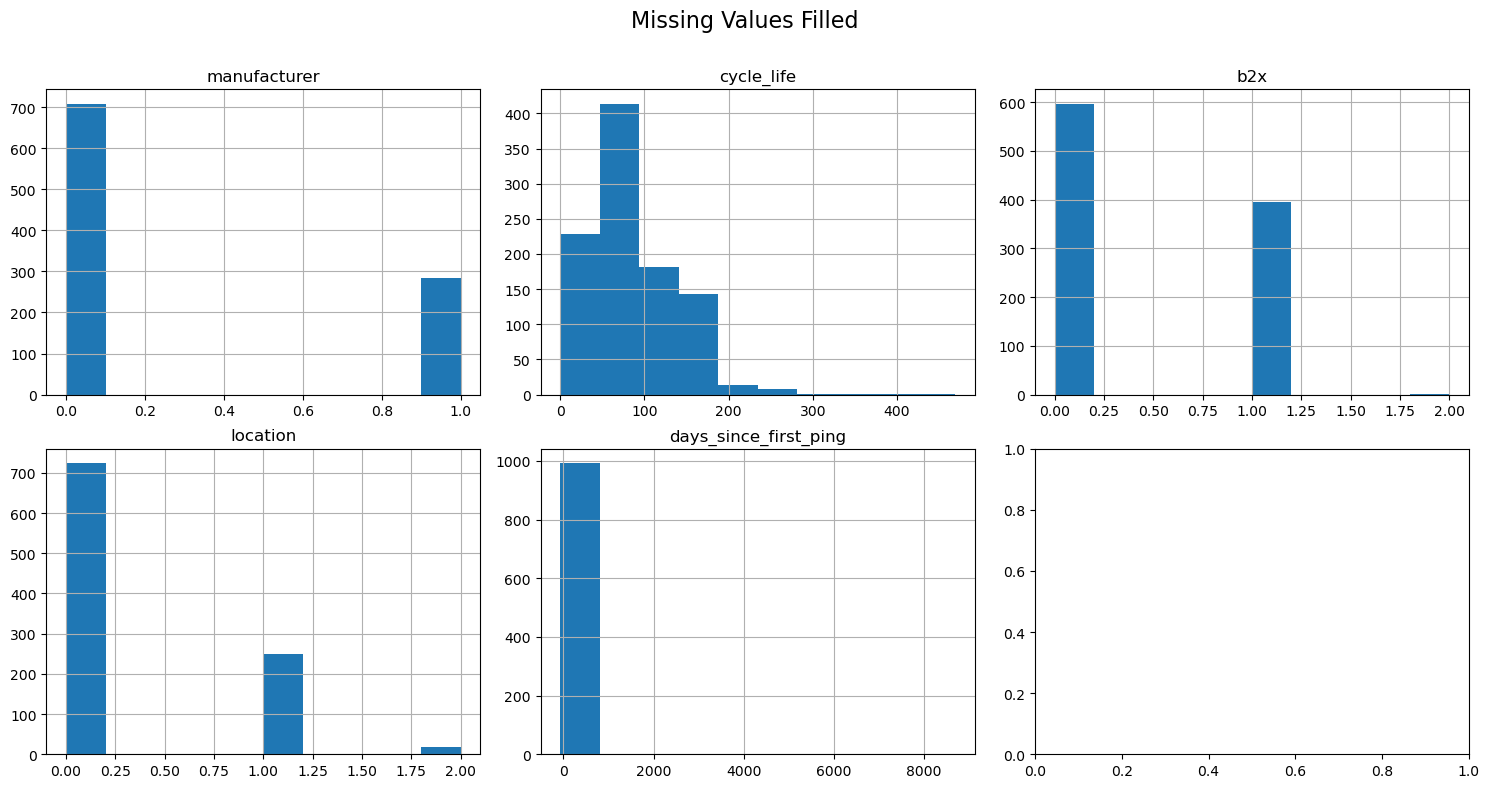

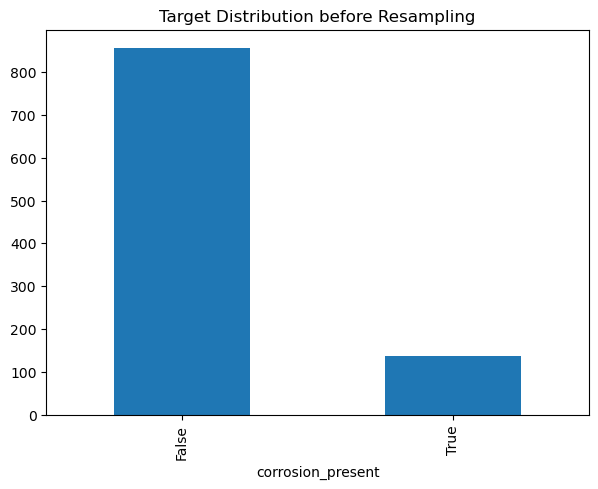

## Establish a baseline score for model ##
Cross-Validation Scores: [0.93081761 0.94339623 0.96226415 0.94339623 0.94936709]
Mean CV Accuracy: 0.9458482604888145


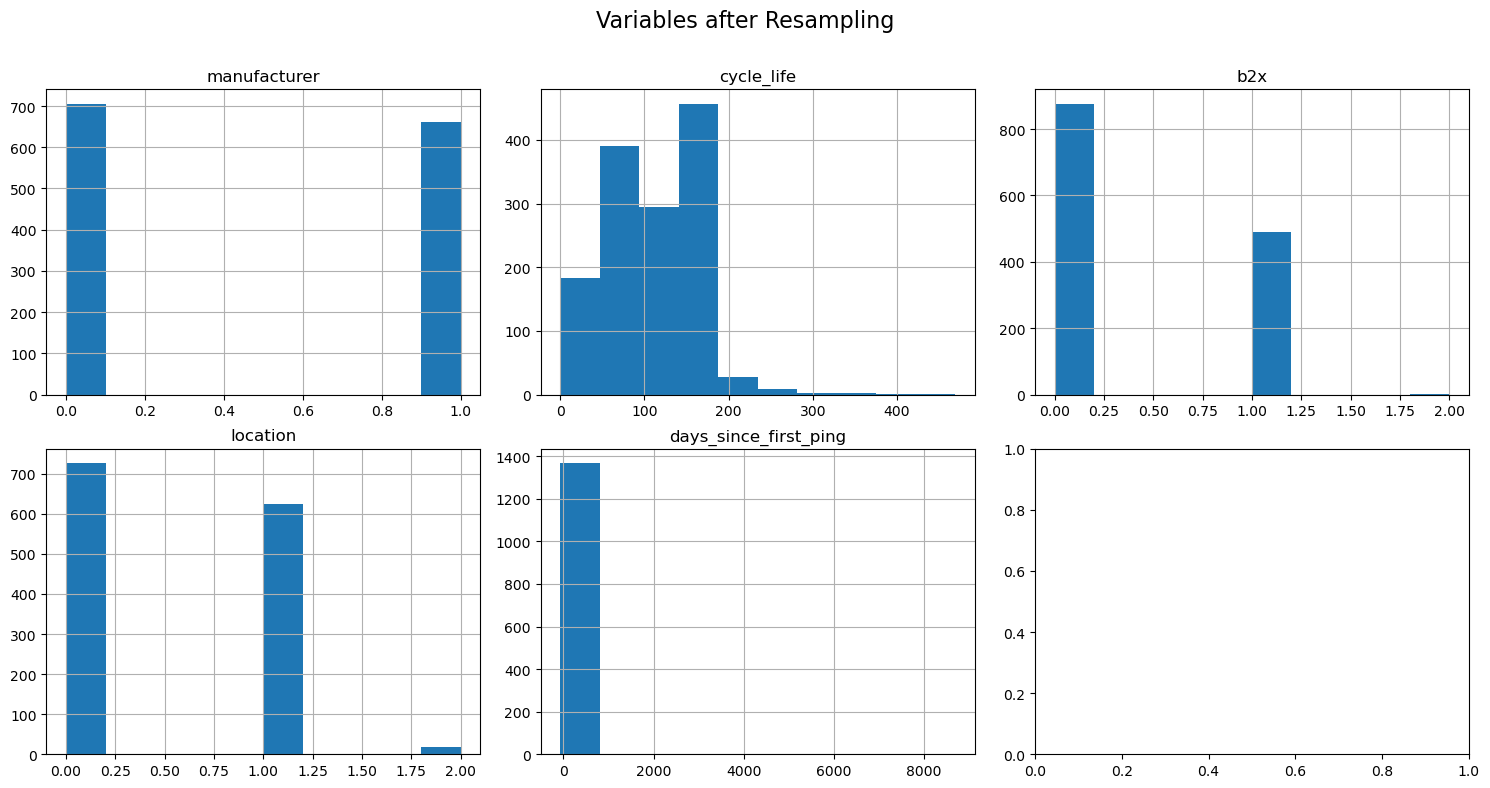

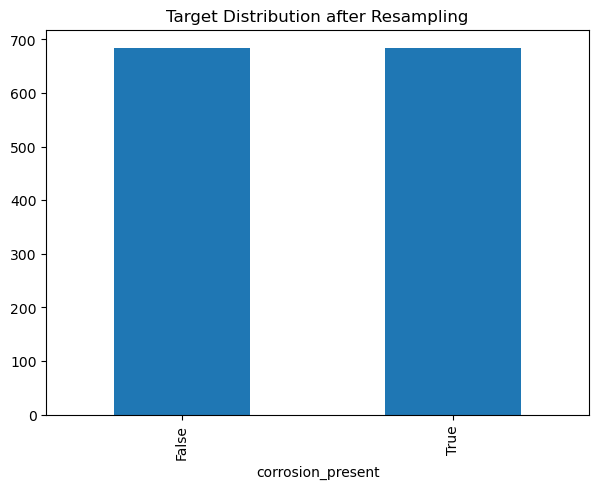

100%|██████████| 250/250 [08:05<00:00,  1.94s/trial, best loss: -0.9843770709283]  
{'colsample_bytree': 0.9997748674813605, 'gamma': 0.23726029478000404, 'learning_rate': 0.051812265499956156, 'max_depth': 13.0, 'min_child_weight': 1.0222578719860937, 'n_estimators': 367.0, 'subsample': 0.7078491924336983}


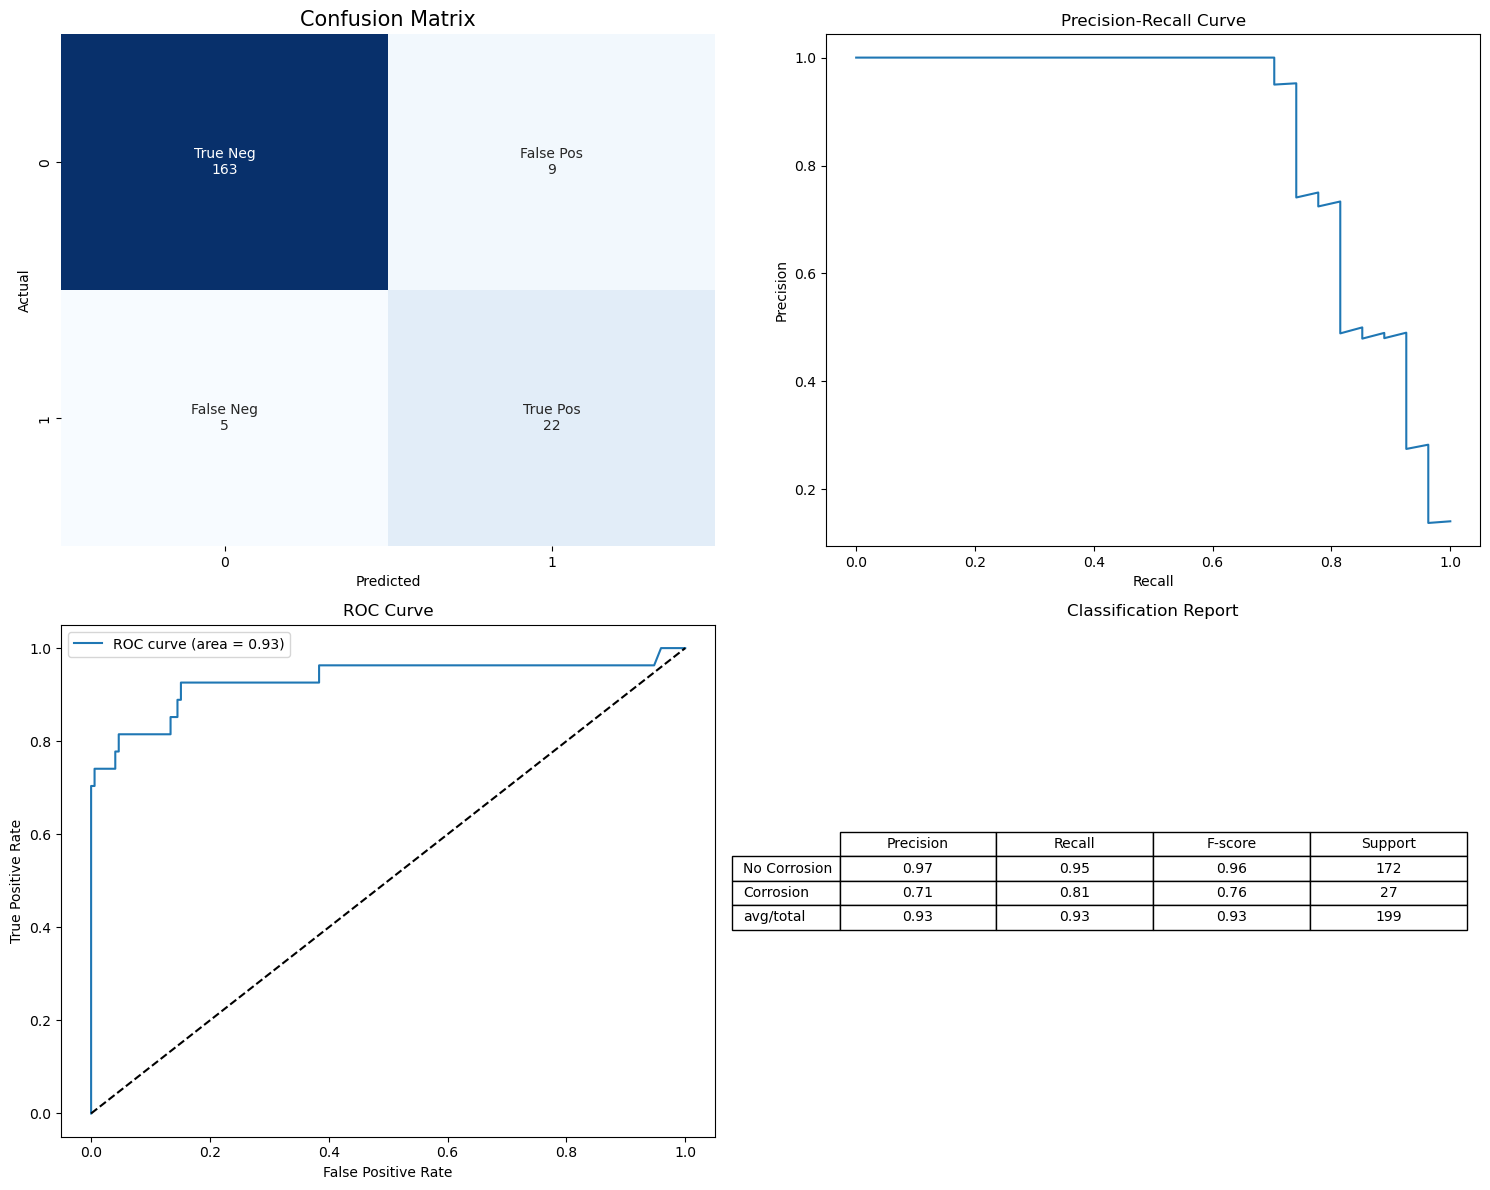

Feature importance:
manufacturer: 0.5011096000671387
location: 0.2564828097820282
cycle_life: 0.11092261970043182
days_since_first_ping: 0.08481273055076599
b2x: 0.046672236174345016


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


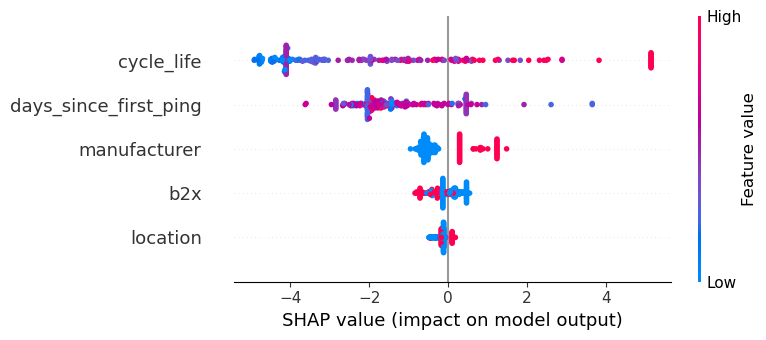

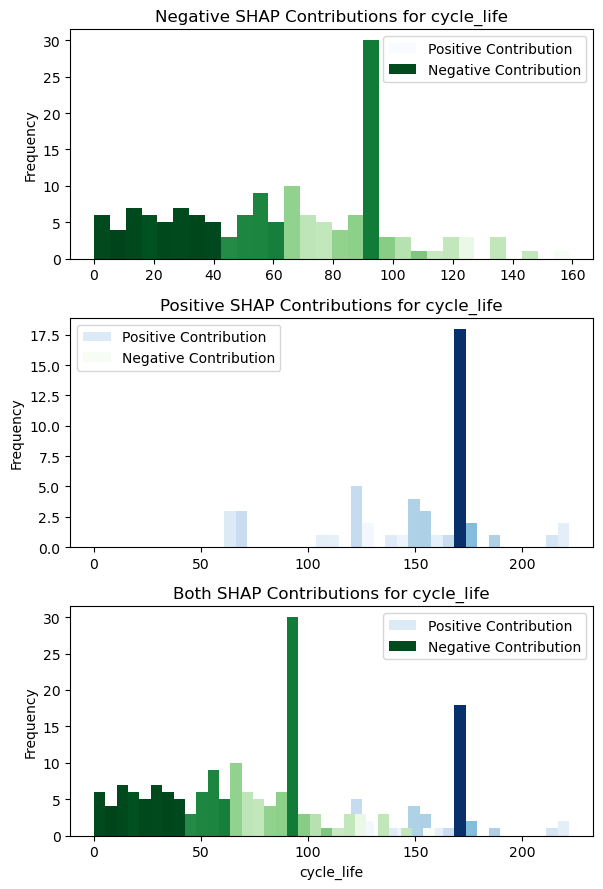

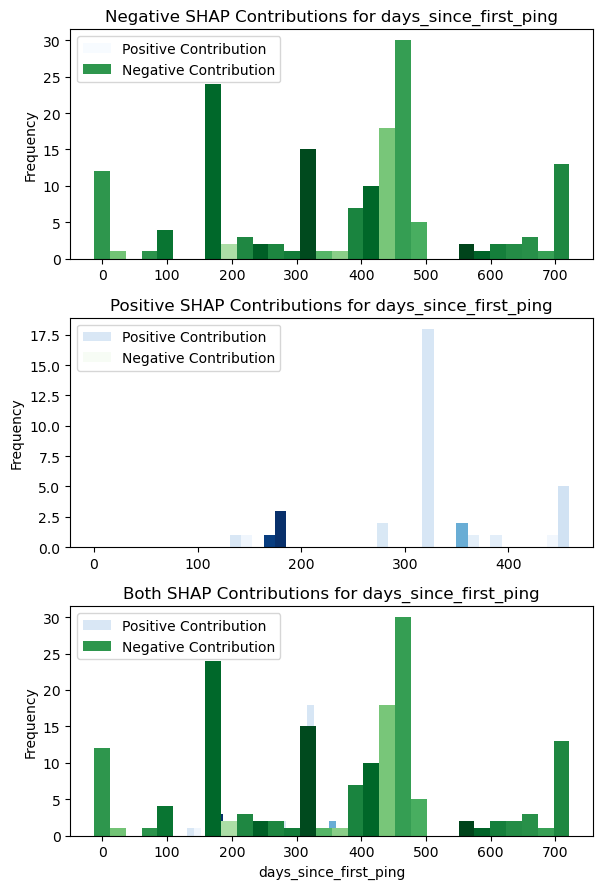

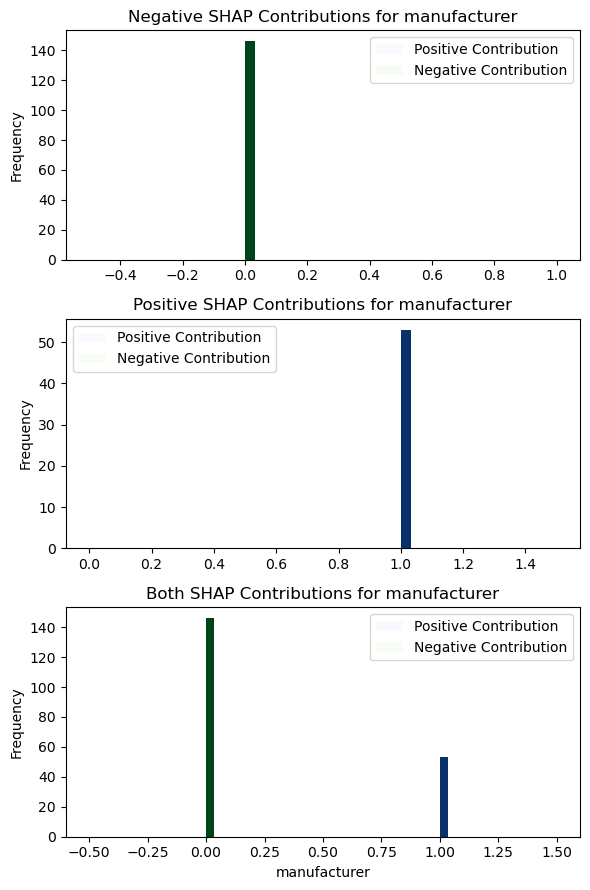

manufacturer {0: 'Hanwin', 1: 'MPS'}


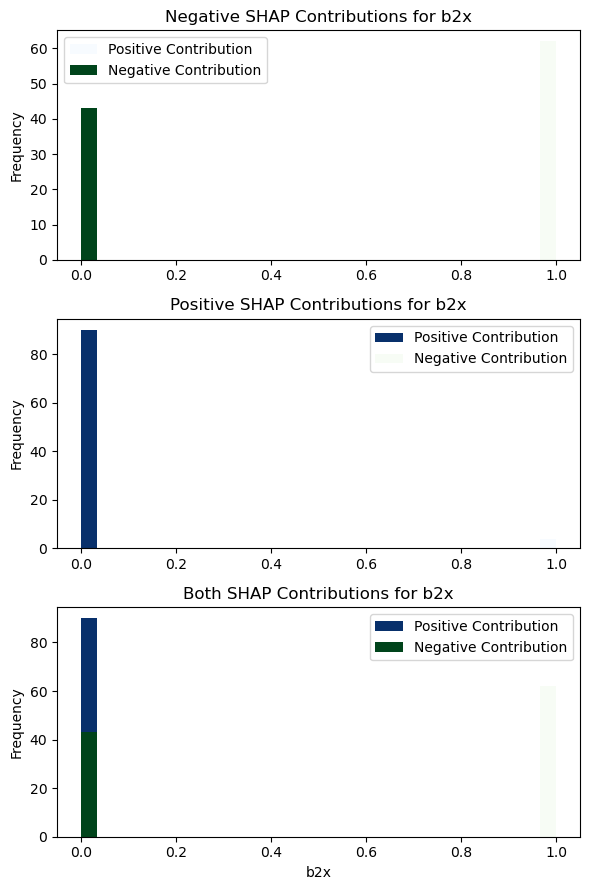

b2x {0: 'B2B', 1: 'B2C', 2: 'Unkown'}


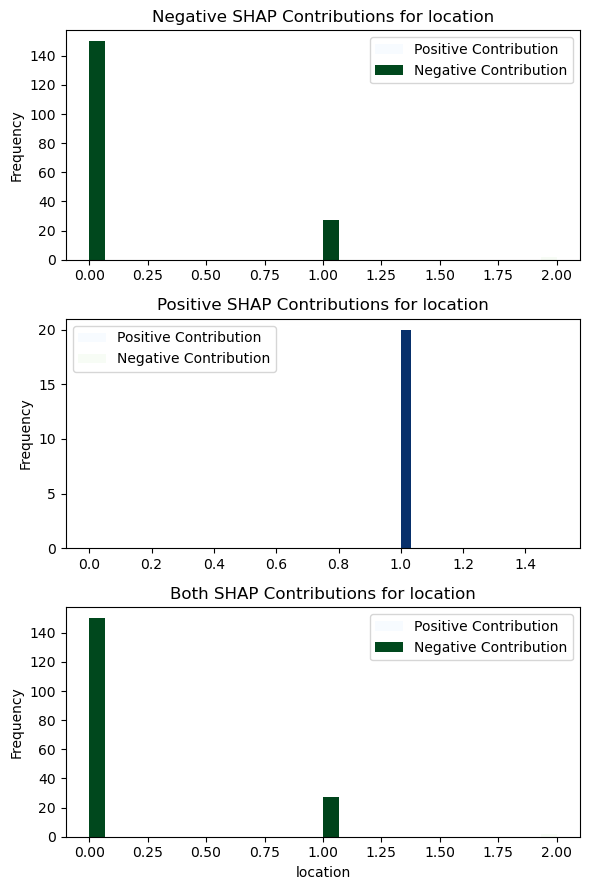

location {0: 'NYC', 1: 'Sydney', 2: 'Toronto'}


['xgb_battery_corrosion_pred.pkl']

In [32]:
# 7. Execute Pipeline
# Define path to the cleaned and combined data
data_path = "../data/clean/combined.csv"

# Load and preprocess the data. The function returns the features (X), target (y), the encoded feature mappings and the original dataframe to re-use the serial numbers
X, y, mappings, original_df = load_and_preprocess_data(data_path)

# Split the dataset into training and testing sets, ensuring that the distribution of the target variable is consistent in both sets using stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Set up cross-validation with StratifiedKFold to ensure that each fold retains the percentage of samples for each class
cv = StratifiedKFold(n_splits=5)

# Initialize the XGBoost Classifier
model = XGBClassifier()

# Perform cross-validation to evaluate the initial performance of the model
cross_val_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

# Print the baseline performance metrics for the model
print("## Establish a baseline score for model ##")
print(f"Cross-Validation Scores: {cross_val_scores}")
print(f"Mean CV Accuracy: {np.mean(cross_val_scores)}")

# Resample the training data to address class imbalance, if present.
X_train_resampled, y_train_resampled = resample_data(X_train, y_train)

# Optimize hyperparameters for the model. 
best_params = optimize_hyperparameters(X_train_resampled, y_train_resampled, 250)

# Train the XGBoost model using the resampled data and the optimized hyperparameters
trained_model = train_model(X_train_resampled, y_train_resampled, X_test, y_test, best_params)

# Compute the probabilities of the positive class for the test set
predicted_probabilities = trained_model.predict_proba(X_test)[:, 1]

# Get the predictions
predictions = trained_model.predict(X_test)

# Add the predicted probabilities, predictions, and the actual corrosion presence to the original test dataframe
X_test_with_probs = X_test.copy()
X_test_with_probs['predicted_probabilities'] = predicted_probabilities
X_test_with_probs['prediction'] = predictions
X_test_with_probs['actual_corrosion_present'] = y_test

# Decode the values of encoded columns back to their original labels
for column in ['manufacturer', 'location', 'b2x']:
    X_test_with_probs[column] = X_test_with_probs[column].replace(mappings[column])

# Merge the serial numbers from the original dataframe
X_test_with_probs = X_test_with_probs.merge(original_df[['sn']], left_index=True, right_index=True, how='left')

# Save the updated test set to a CSV file
X_test_with_probs.to_csv('predictions.csv', index=False)

# Evaluate the model's performance on the test set. This function likely computes and prints metrics such as accuracy, precision, recall, F1-score, etc.
evaluate_model(trained_model, X_test, y_test)

# Conduct feature importance analysis on some specified features using SHAP values or other methods to interpret the model
features_to_analyse = ['cycle_life', 'days_since_first_ping', 'manufacturer', 'b2x','location']
feature_analysis(trained_model, X_test, features_to_analyse, mappings)

# Save the trained model to a file
joblib.dump(trained_model, 'xgb_battery_corrosion_pred.pkl')